In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rn
import matplotlib.pyplot as plt

In [2]:
X_train = np.loadtxt(open("digits/X_digits_train.csv", "rb"), delimiter=" ")
y_train = np.loadtxt(open("digits/y_digits_train.csv", "rb"), delimiter=" ")
X_test = np.loadtxt(open("digits/X_digits_test.csv", "rb"), delimiter=" ")
y_test = np.loadtxt(open("digits/y_digits_test.csv", "rb"), delimiter=" ")
C = 10

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1198, 64)
(599, 64)
(1198,)
(599,)


In [4]:
def objective(X, y, beta, C):
    N = X.shape[0]
    sizeX = X.shape[1]
    #obj3 = mu*la.norm(beta)
    
    obj = 0
    tempVec = np.zeros(C)
    for i in range(X.shape[0]):
        x = X[i,:]
        obj1 = np.dot(beta[int(y[i]*X.shape[1]):int((y[i]*X.shape[1]+X.shape[1]))],x)
        for j in range(C):
            tempVec[j] = np.exp(-np.dot(beta[j*sizeX:(j*sizeX+sizeX)], x))
        obj2 = np.log(np.sum(tempVec))
        
        obj += obj1 + obj2
    
    obj = 1/N*(obj) #+ obj3
    return obj

In [20]:
def gradient1(x, y, beta, C, N, mu):
    sizeBeta = beta.shape[0]
    sizeX = sizeBeta/C
    grad1 = np.zeros(sizeBeta)
    grad1[int(y*sizeX):int(y*sizeX + sizeX)] = x
    
    grad3 = mu/N*beta
    
    tempVec = np.zeros(C)
    tempVec2 = np.zeros(sizeBeta)
    
    for j in range(C):
        betatemp = beta[int(j*sizeX):int(j*sizeX+sizeX)]
        tempVec[j] = np.exp(-np.dot(betatemp, x))
        
        tempVec2[int(j*sizeX):int(j*sizeX+sizeX)] = -x*tempVec[j]
    
    grad2 = tempVec2/np.sum(tempVec)
    
    return (grad1 + grad2 + grad3)

In [6]:
def gradient2(X, Y, beta, C, mu):
    
    grad = np.zeros(beta.shape[0])
    N = X.shape[0]
    for i in range(N):
        x = X[i,:]
        y = Y[i]
        
        grad += grad + gradient1(x, y, beta, C, N, 0)
        
    return 1/N*grad + mu*beta

In [22]:
def grad(X, y, beta, C, mu):
    sizeX = X.shape[1]
    N = X.shape[0]
    
    tempVec2 = np.zeros(sizeX*C)
    grad2 = np.zeros(sizeX*C)
    for i in range(X.shape[0]):
        tempVec = np.zeros(C)
        tempVec2 = np.zeros(sizeX*C)
        tempgrad = np.zeros(sizeX*C)
        
        x = X[i,:]
        tempgrad[int(y[i]*sizeX):(int(y[i]*sizeX+sizeX))] = x
        
        for j in range(C):
            tempVec[j] = np.exp(-np.dot(beta[int(j*sizeX):int((j*sizeX+sizeX))], x))
            tempVec2[j*sizeX:j*sizeX + sizeX] = -x*tempVec[j]
        grad1 = tempVec2/np.sum(tempVec)
        
        grad2 = grad1 + tempgrad + grad2

    grad3 = mu*beta
    
    grad = 1/N*grad2 + grad3 
    
    return grad

In [8]:
def gradient(X, Y, beta, C, mu, t):
    eta = 1e-3/np.sqrt(t+1)
    
    beta = beta - eta*grad(X, Y, beta, C, mu)
    
    return beta

In [9]:
def stochgradient(x, y, beta, C, mu, N, t):
    eta = 1e-3/np.sqrt(t+1)
    
    beta = beta - eta*gradient1(x, y, beta, C, N, mu)
    
    return beta

In [16]:
def SVRG(X, Y, beta, C, mu, t):
    eta = 1e-3/np.sqrt(t+1)
    T = 100
    
    randset = rn.randint(X.shape[0], 100)
    
    fullgrad = grad(X, Y, beta, C, mu)
    beta0 = beta
    N = X.shape[0]
    
    for i in range(T):
        x = X[randset[i],:]
        y = Y[randset[i]]
        
        grad_t = gradient1(x, y, beta, C, N, mu)
        grad_0 = gradient1(x, y, beta0, C, N, mu)
        
        beta = beta - eta*(grad_t - grad_0 + fullgrad)
    
    return beta

In [11]:
def descent(update, X, Y, X_test, Y_test, C, mu):
    train = []
    test = []
    
    beta = np.zeros(X.shape[1]*C)
    
    T = 10
    
    for t in range(T):
        beta = update(X, Y, beta, C, mu, t)
        
        if(t % 1 == 0) or (t == T - 1):
            train.append(objective(X, Y, beta, C))
            test.append(objective(X_test, Y_test, beta, C))
            
            assert not np.isnan(train[-1])
        
    return beta, train, test

In [14]:
def descent2(update, X, Y, X_test, Y_test, C, mu):
    train = []
    test = []
    
    beta = np.zeros(X.shape[1]*C)
    N = X.shape[1]
    
    T = 10
    
    for t in range(T):
        i = rn.randint(X_train.shape[0])
        x = X[i,:]
        y = Y[i]
        beta = update(x, y, beta, C, mu, N, t)
        
        if(t % 1 == 0) or (t == T - 1):
            train.append(objective(X, Y, beta, C))
            test.append(objective(X_test, Y_test, beta, C))
            
            assert not np.isnan(train[-1])
            
    return beta, train, test

In [ ]:
beta_gd, train_gd, test_gd = descent(gradient, X_train, y_train, X_test, y_test, C, 1)

In [15]:
beta_sg, train_sg, test_sg = descent2(stochgradient, X_train, y_train, X_test, y_test, C, 1)

In [23]:
beta_sv, train_sv, test_sv = descent(gradient, X_train, y_train, X_test, y_test, C, 1)

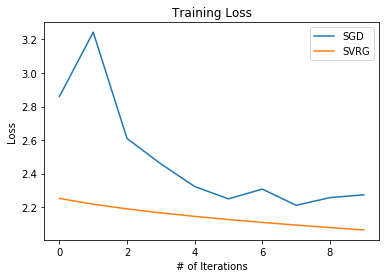

In [33]:
%matplotlib inline
plt.plot(train_sg, label="SGD")
plt.plot(train_sv, label="SVRG")
plt.xlabel("# of Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

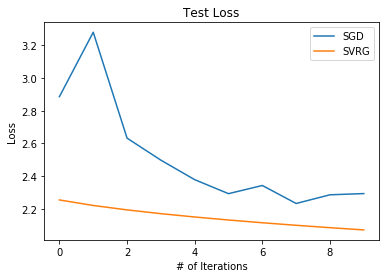

In [34]:
%matplotlib inline
plt.plot(test_sg, label="SGD")
plt.plot(test_sv, label="SVRG")
plt.xlabel("# of Iterations")
plt.ylabel("Loss")
plt.title("Test Loss")
plt.legend()